In [71]:
#Classification of MNIST dataset 
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using MLDatasets
using IterTools #Only for plots, not for program

#include("hmc_mod.jl")
#include("helper_functions.jl")
#include("rj_proposals.jl")
include("mnist.jl")
include("utils.jl");

In [8]:
#Load the MNIST Data
x_train, y_train = load_mnist_train_set()
x_test, y_test = load_mnist_test_set()

x, y = balanced_set(x_train,y_train,10);

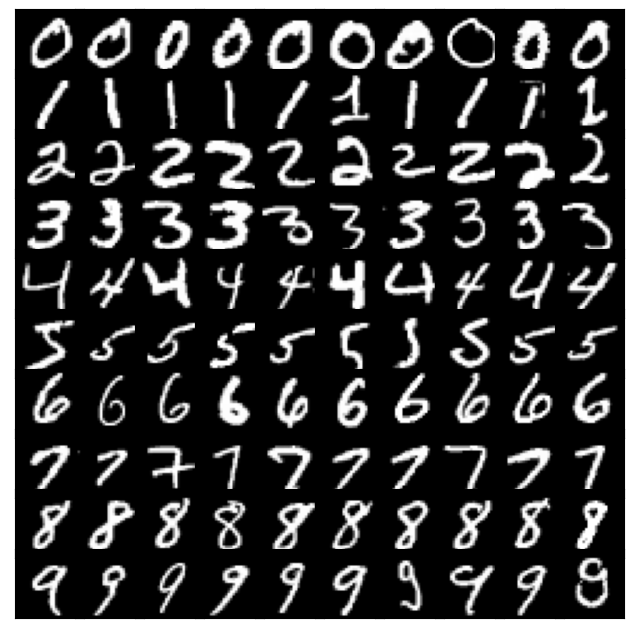

In [9]:
#Visualize Samples
x_reshaped = reshape_x(x)

nrow, ncol = 10, 10
fig = figure("plot_mnist",figsize=(6,6))
for (i, (c, r)) in enumerate(Iterators.product(1:ncol, 1:nrow))
    subplot(nrow, ncol, i)
    imshow(x_reshaped[:,:,i]', cmap="gray")
    ax = gca()
    ax.xaxis.set_visible(false)
    ax.yaxis.set_visible(false)
end;
tight_layout(w_pad=-1, h_pad=-1, pad=-0.5);

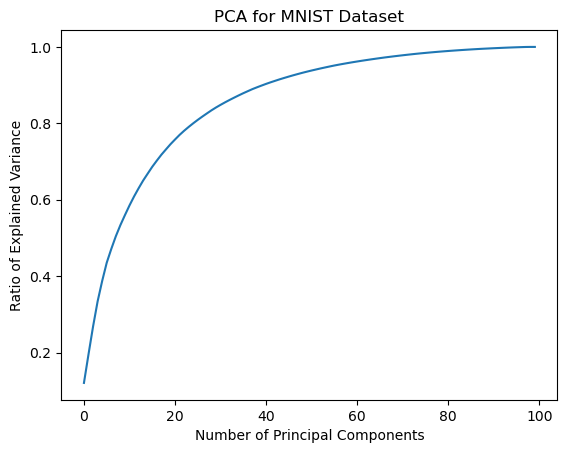

In [10]:
#Run PCA to lower dimensionality of MNIST (later, for now try big params)
vars = []
x = transpose(x)
for i=1:100    
    MNIST_PCA = fit(PCA, x, maxoutdim=i, pratio=1.0)
    push!(vars,MNIST_PCA.tprinvar/MNIST_PCA.tvar)
end
plot(vars)
plt.title("PCA for MNIST Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Ratio of Explained Variance");

In [11]:
#Get PCA Transform for x
dims = 20
x_pca = fit(PCA,x,maxoutdim=dims)
#xt = projection(x_pca)
xt = transform(x_pca,x)

20×100 Array{Float64,2}:
 -3.82927    -3.87763   -3.85104   …   1.24748    2.37387    -2.25826
  0.0514399   0.887463   0.709426     -0.869054   0.81576    -1.248
 -2.99617    -3.03776   -1.11247      -0.742939  -2.0389      0.585694
  0.664484   -0.244185   2.01694      -2.44701   -0.415278    0.29815
 -0.615256   -1.81415    1.20737       2.22694    2.04987    -1.56755
  3.12412     3.47828    0.292043  …  -2.12594   -0.934967    0.279278
 -1.62091    -0.99969    1.59087      -0.281429   0.800214   -0.180015
  1.56826     2.01259   -1.16062       0.637769   0.179977   -0.873783
 -0.537883    0.244669  -0.544265     -1.91983    0.917253    1.45009
  0.310284    0.880762  -1.99156       1.47027    0.943666   -0.438198
 -0.683858   -0.41424   -0.8826    …  -0.951439  -0.843343   -1.25328
  0.460399    0.765701   1.76854      -0.42143   -0.728503   -3.06743
 -2.35852    -1.97312    0.750627      1.65579   -0.554579    1.89389
  0.574915   -0.199751   2.2151       -0.14686    1.0655     -

In [12]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"

#Data hyperparameters
n = 10 #Number of samples
c = 10 #Number of classes
d = dims #Input dimension
N = n*10 #Total samples

#Network hyperparameters
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape

#Node hyperparameters
k_range = 20 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]

#NUTS
Δmax = 1000;

In [18]:
#Bayesian Neural Net
function G(x, trace)
    activation = relu
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], c, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], c)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

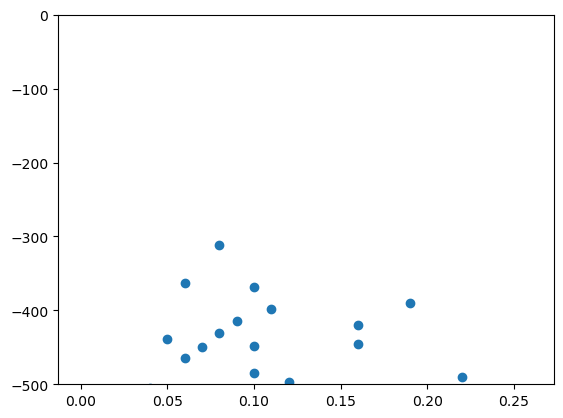

-920.681997090606
7


(-500.0, 0.0)

In [95]:
@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers - 1 for Classifier Net
    l ~ categorical([1.0])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    output_array = zeros(Float64, 10)
    output_array[10] = 1.0

    k[l+1] = @trace(categorical(output_array), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ##################################################
    #Adapted from BH: hyperparameter schedule - Apr 3#
    ##################################################
    
    α₁ = 1 #Input Weights, Biases Shape
    β₁ = 1 #Input Weights, Biases Scale/Rate
    α₂ = 1 #Hidden & Output Weights Shape
    β₂ = k[1] #Scale Hyperparameter Based on Number of Nodes
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])   
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(10)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)]) 
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = logsoftmax(scores,dims=1)
    scores = exp.(scores)
    
    #Logistic Regression Likelihood
    y = zeros(length(scores))
    for j=1:length(x[1,:])
        score_vec = scores[:,j]
        y[j] = @trace(categorical(score_vec), (:y,j))
    end

    return scores
    
end;

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

(best_trace,) = generate(classifier, (xt,), obs)
println(get_score(best_trace))
test_labels = exp.(logsoftmax(G(xt,best_trace)))
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])

scores = []
accs = []
for i = 1:1000
    (trace,) = generate(classifier, (xt,), obs)
    push!(scores,get_score(trace))
    test_labels = exp.(logsoftmax(G(xt,trace)))
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    push!(accs,test_acc)
end

scatter(accs,scores)
plt.ylim(-500,0)

#test = test_scores = classifier(x)
#test_labels = data_labeller(test_scores)


In [107]:
#Straight NUTS
include("NUTS.jl")
Δ_max = 1000

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        β₂ = trace[(:k,1)]
        
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

m=10
iters=100

(best_trace,) = generate(classifier, (xt,), obs)
best_k = best_trace[(:k,1)]
println("Starting ks: $best_k")
traces = []
push!(traces,best_trace)

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

for i=1:iters
    
    trace_star = traces[i]
    if i%10 == 0
        println("Iteration $i: $(get_score(trace_star))")
    end
    trace_star = gibbs_hyperparameters(trace_star)
    trace_star, accepted = nuts_parameters(trace_star)

    push!(traces,trace_star)
end

Starting ks: 17
Inf warning
Inf warning


InterruptException: InterruptException:

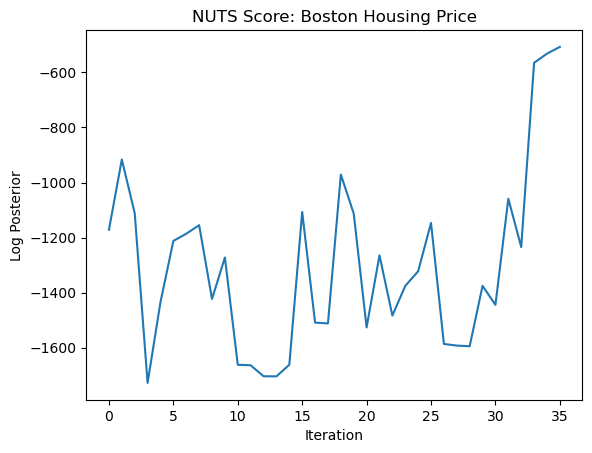

In [106]:
plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

In [ ]:
#--------------------
#RJMCMC - using NUTS
#--------------------
traces = []
scores = []
acc = []

obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs_master[:l] = 5
for i = 1:6
    obs_master[(:k, i)] = hidden_nodes
end
obs = obs_master;

function sample_HMC(trace, iters, obs)
    for i=1:iters
        prev_trace = trace
        trace, obs = select_hyperparameters(prev_trace, obs)
        eps = uniform(0.1,1.6)
        selection = select_selection(trace)
        (new_trace, hmc_score) = hmc_mod(trace, selection, L=3, eps=eps, check=false, observations=obs)
        new_score = get_score(new_trace)
        old_score = get_score(prev_trace)
        score = new_score - old_score
        println(score)
        if rand(Uniform(0,1)) < exp(score)
            trace = new_trace
            accepted = 1.0
            #println("Accepted")
        else
            trace = prev_trace
            accepted = 0.0
            #println("Not Accepted")
        end
        push!(traces, trace)
        push!(acc, accepted)
        if i%5 == 0
            println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
        end
    end
    return trace     
end

obs_blank = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_blank[(:y,i)] = classes[i]
end

(starting_trace,) = generate(classifier, (x,), obs)
#get_score(starting_trace)

sample_HMC(starting_trace, 200, obs)

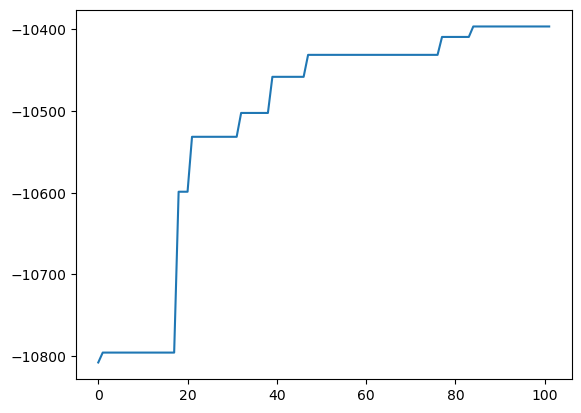

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5279d26fd0>

In [135]:
scores = [get_score(trace) for trace in traces]
plot(scores)

In [138]:
best_trace = traces[:20]
score_test = G(x,best_trace)
scores_test = logsoftmax(score_test,dims=1)
scores_test = exp.(scores_test)
function mnist_labeller(y::Array{Float64})
    labels = [float(argmax(y[:,i])) for i=1:length(classes)]
    return labels
end

labels = mnist_labeller(scores_test)

function mnist_accuracy(labels::Array{Float64},classes::Array{Float64})
    acc = [classes[i] == labels[i] ? 1.0 : 0.0 for i=1:length(classes)]
    total_acc = sum(acc)/length(acc)
    return total_acc
end

mnist_accuracy(labels,classes)

0.1